##0.Librerías necesarias

In [44]:
#!pip install rarfile
#!pip install unzip
!pip install pandas
!pip install numpy
!pip install stop-words
!pip install num2words


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
#Librerias necesarias
import numpy as np
import pandas as pd
from google.colab import drive
import random
#import rarfile # para descomprimir archivos
import json
#import csv 
#para limpiar los datos
import nltk
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
nltk.download('omw-1.4')
import string
import unicodedata
from num2words import num2words
#para reducir la dimensión
from sklearn.manifold import TSNE
#para representar
import matplotlib.pyplot as plt

#análisis exloratorio
from collections import Counter
from nltk import ngrams
from nltk.probability import FreqDist
from wordcloud import WordCloud

#preprocesado
from stop_words import get_stop_words
import unicodedata
import re

#modelado
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#reporte
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


##1. Carga de datos

In [4]:
# Montamos GDrive para almacenar los datos
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pwd

/content


In [ ]:
#with rarfile.RarFile('/content/drive/MyDrive/NLP/filter_all_t.json', 'r') as rf:
#  rf.extractall('./content')

In [7]:
#Localizamos el archivo y lo leemos
path = '/content/drive/MyDrive/NLP/'

with open(f'{path}filter_all_t.json', 'r') as f:
  data = json.load(f)

data = data['train']#[10000]  #subset de las primeras 10000 líneas
data

[{'business_id': '60567465d335d0abfb415b26',
  'user_id': '101074926318992653684',
  'rating': 4,
  'review_text': 'The tang of the tomato sauce is outstanding. And the crust is a meal, as it should be. Order a whole pie fresh.',
  'pics': ['AF1QipM-2IRmvitARbcJr7deWfe5hyVBg_ArPMQSYvq0',
   'AF1QipPWhe1OP80YPU40J6-XIdxbJIe57vKm8TTjve31',
   'AF1QipNuKWM65S9ZFQykvdIhKUliE6K1VBxssTUYyl8d',
   'AF1QipOJng1JS_1hmpfhAVrr7hE89dcoOtdy-Z6cOO9x'],
  'history_reviews': [['101074926318992653684_6056272797d555cc6fb0d147',
    'The pizza here is the real deal, perfect in every way except for the crust, which was more cracker crisp than chewy bread. Also recommend the meatball parmigiana hero, beefy, fluffy, overflowing, tangy, chunky tomato sauce, toothsome bread.'],
   ['101074926318992653684_604a65c2c6dc737bce7e5a3d',
    'Omg the tomato sauce is everything, in the meatball appetizer, pizza & as a dip for that scratch-made focaccia. Farm-fresh salad. A variety of artisan toppings. Ask for the chi

In [8]:
#Creamos el df 
reviews_text = []
reviews_sentiment = []

for review in data:
    reviews_text.append(review.get('review_text'))
    reviews_sentiment.append(review.get('rating'))

df= pd.DataFrame({
    'review_text': reviews_text,
    'reviews_sentiment': reviews_sentiment
})
df.dropna(subset=['review_text', 'reviews_sentiment'], inplace=True)
df.reset_index(drop=True, inplace=True)
df

,review_text,reviews_sentiment
0,The tang of the tomato sauce is outstanding. A...,4
1,Chicken and waffles were really good!,5
2,The appetizer of colossal shrimp was very good...,4
3,The fish tacos here omg! The salad was great ...,5
4,"Ribs are great, as are the mac and cheese, fri...",4
...,...,...
87008,The tacos were just okay.,3
87009,I had the Pasta Mardi Gras,5
87010,We order the Pork Bar-B-Que pizza (our favorit...,4
87011,"Beer was very tasty, The Alt was one of my fav...",5


In [9]:
#observo la cantidad de ratings distintos que hay para ver si debo hacer un balance
print(Counter(df['reviews_sentiment'].tolist())) 

Counter({5: 54665, 4: 22333, 3: 6918, 2: 2027, 1: 1070})


In [10]:
#creo una función que me estrae de forma aleatoria un porcentaje de muestras positivas y negativas

rows_pos = 0.05 #elijo el porcentaje de datos positivos que voy a extraer 
rows_neg = 0.25 #datos negativos

def Balance(df):
  ''' 
  df: dataframe a balancear
  '''
  #defino las muestras negativas que me quiero quedar
  df_positive= df[df['reviews_sentiment']>= 4].sample(frac = rows_pos, replace=True) 
  
  #defino las muestras positivas que me quiero quedar
  df_negative = df[df['reviews_sentiment']<=3].sample(frac= rows_neg, replace=True)

  #concateno todo, y añado los negativos a mi df
  df_balanced = pd.concat([df_positive, df_negative]).sample(frac=1).reset_index(drop=True)

  #reseteo los índices
  #df_balanced.reset_index(drop=True, inplace=True)

  return df_balanced

df_balanced = Balance(df)
df_balanced


,review_text,reviews_sentiment
0,The skin on the hot dogs is the super tough kind.,2
1,The wings are good and the fajita philly chees...,5
2,"The fried chicken wings were tasty, but it's k...",3
3,Great dry rub on the ribs and the wet sauce is...,5
4,"However, all of our steaks were overcooked ...",4
...,...,...
6349,"Thurman's has the best, biggest, burgers in Co...",5
6350,Was not expecting a rare burger.,3
6351,Seafood is not fresh . The most delicious is t...,1
6352,I recommend the Italian sausage omelette!,5


In [ ]:
#observo la cantidad de ratings distintos que hay para ver el balance
print(Counter(df_balanced['reviews_sentiment'].tolist())) 

Counter({5: 2759, 3: 1739, 4: 1091, 2: 500, 1: 265})


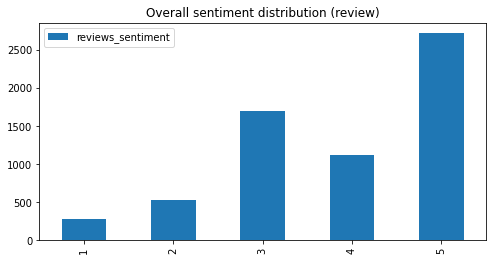

In [11]:
#mostramos la gráfica para ver como se distribuyen los ratings
aux_df = pd.DataFrame(df_balanced['reviews_sentiment'].value_counts(sort=False).sort_index()) #creo un df solo con los ratings
aux_df = aux_df.plot(kind='bar', title='Overall sentiment distribution (review)', figsize=(8, 4)) #lo ploteo

In [12]:
#split en train y test de del df_data
train, test = train_test_split(df_balanced, test_size = 0.25)

print("Ejemplos usados para entrenar: ", len(train))
print("Ejemplos usados para test: ", len(test))

Ejemplos usados para entrenar:  4765
Ejemplos usados para test:  1589


##2. Análisis exploratorio

### 2.1. Primero el análisis del conjunto de entrenamiento

In [13]:
train

,review_text,reviews_sentiment
1898,When the pie arrived it was missing one of the...,2
1889,Burger was fabulous. Bacon tasted like one fro...,5
5005,"Some of the food was very good - chicken, spam...",3
203,This is a solid taco place. But their tortilla...,4
2890,"I had the mahi mahi tacos, which were pretty g...",4
...,...,...
4952,"Its an Ok burger for the price. The Fries, usu...",4
2216,I ordered the Cheesy Todd cheeseburger which h...,3
2980,"The coffee is surprisingly good, omeletes are ...",3
1196,It's no secret they've got the best burgers ar...,5


In [14]:
#convertimos en minúsculas y tokenizamos por espacios 
reviews = train['review_text'].str.lower().str.split() 
train.head()

,review_text,reviews_sentiment
1898,When the pie arrived it was missing one of the...,2
1889,Burger was fabulous. Bacon tasted like one fro...,5
5005,"Some of the food was very good - chicken, spam...",3
203,This is a solid taco place. But their tortilla...,4
2890,"I had the mahi mahi tacos, which were pretty g...",4


#### 2.1.1. Cardinalidad del vocabulario

In [15]:
def word_count(text):
    # Tokenizar el texto
    tokens = nltk.word_tokenize(text)
    # Eliminar las palabras vacías
    tokens = [word for word in tokens if word not in stopwords.words('spanish')]
    return tokens

In [16]:
train['words'] = train['review_text'].apply(word_count)
train.head()

,review_text,reviews_sentiment,words
1898,When the pie arrived it was missing one of the...,2,"[When, the, pie, arrived, it, was, missing, on..."
1889,Burger was fabulous. Bacon tasted like one fro...,5,"[Burger, was, fabulous, ., Bacon, tasted, like..."
5005,"Some of the food was very good - chicken, spam...",3,"[Some, of, the, food, was, very, good, -, chic..."
203,This is a solid taco place. But their tortilla...,4,"[This, is, solid, taco, place, ., But, their, ..."
2890,"I had the mahi mahi tacos, which were pretty g...",4,"[I, had, the, mahi, mahi, tacos, ,, which, wer..."


In [17]:
#creamos una lista con la suma de las palabras de todas las reviews
words = list(train['words'].sum())
words

['When',
 'the',
 'pie',
 'arrived',
 'it',
 'was',
 'missing',
 'one',
 'of',
 'the',
 'ordered',
 'toppings',
 '.',
 'If',
 'I',
 'pay',
 '$',
 '34',
 'for',
 '1',
 'pie',
 'I',
 'prefer',
 'it',
 'to',
 'be',
 'correct',
 '.',
 'Burger',
 'was',
 'fabulous',
 '.',
 'Bacon',
 'tasted',
 'like',
 'one',
 'from',
 'green',
 'street',
 'meat',
 'house',
 '.',
 'Some',
 'of',
 'the',
 'food',
 'was',
 'very',
 'good',
 '-',
 'chicken',
 ',',
 'spam',
 ',',
 'other',
 'meats',
 '.',
 'This',
 'is',
 'solid',
 'taco',
 'place',
 '.',
 'But',
 'their',
 'tortillas',
 'are',
 'bit',
 'too',
 'soft',
 '.',
 'I',
 'had',
 'the',
 'mahi',
 'mahi',
 'tacos',
 ',',
 'which',
 'were',
 'pretty',
 'good',
 'for',
 'landlocked',
 'Tucson',
 ',',
 'and',
 'the',
 'cevich',
 ',',
 'which',
 'needs',
 'work',
 '.',
 'If',
 'the',
 'cevich',
 'had',
 'Serrano',
 'chiles',
 ',',
 'cucumber',
 ',',
 'and',
 'caldo',
 'camaron',
 'to',
 'round',
 'out',
 'the',
 'lemon',
 'juice',
 ',',
 'it',
 "'d",
 'be'

In [18]:
#visualizamos las palabras sin duplicados
unique_word= list(set(train['words'].sum()))
unique_word

['parboiled/',
 'complimentary',
 'outlaw',
 'foto',
 'flower',
 'Mexicans',
 'believe',
 'Tso',
 'Overpriced',
 '1/2-soup',
 'Caribbean',
 'styles',
 'travel',
 'cesar',
 'overstuffed',
 'smothered',
 'curd',
 'saki',
 'shabu',
 'sunny',
 'want',
 'fra',
 'nothing',
 'Dogs',
 'sitting',
 'MUFFALETTA',
 'mild',
 'Instant',
 'unselfish',
 'french',
 'strawberry',
 'sodium',
 'Tipsy',
 '5.99',
 'rasgulla',
 'arroz',
 'classical',
 'avenue',
 'ventured',
 'overeasy',
 'cereal',
 'Tartar',
 'Pub',
 "'all",
 'Haha',
 'politely',
 'Change-Up',
 'Crabs',
 'Purchased',
 'one.The',
 'family-run',
 'croissants',
 'Mondays',
 'racing',
 'sue',
 'anniversary',
 'supermarket',
 'ghanoush',
 'power',
 'easily',
 'consider',
 'port',
 'potsticker',
 'Bo-Pie',
 'Bhurjee',
 'aoli',
 'ps',
 'wrong',
 'fantastici',
 'observe',
 'Box',
 'celery',
 'pairing',
 'cohesion',
 'Chef',
 'judged',
 'regardless',
 'French',
 'kinds',
 'mom',
 'hallibut',
 'noodles',
 'decided',
 'States',
 'Frickin',
 'misma',
 '

In [19]:
total_words = len(words)
total_words

139491

In [20]:
total_unique_words = len(unique_word)
total_unique_words

9675

#### 2.1.2. Análisis de sentimiento

In [21]:
#analizo el sentimiento en el punto medio 
train[train['reviews_sentiment']== 3]

,review_text,reviews_sentiment,words
5005,"Some of the food was very good - chicken, spam...",3,"[Some, of, the, food, was, very, good, -, chic..."
4132,The people working need a smile :). Music - ye...,3,"[The, people, working, need, smile, :, ), ., M..."
3092,"Got the spicy ramen, noodles were springy, but...",3,"[Got, the, spicy, ramen, ,, noodles, were, spr..."
4064,"In the photo, I can not see the LA Ribs 2 line...",3,"[In, the, photo, ,, I, can, not, see, the, LA,..."
2373,"You definitely have to order the oysters, it's...",3,"[You, definitely, have, to, order, the, oyster..."
...,...,...,...
4988,The frosty was wonderful.,3,"[The, frosty, was, wonderful, .]"
5959,I ordered a double quarter pounder with cheese...,3,"[I, ordered, double, quarter, pounder, with, c..."
2917,The chicken philly sub is okay... Thats all we...,3,"[The, chicken, philly, sub, is, okay, ..., Tha..."
2216,I ordered the Cheesy Todd cheeseburger which h...,3,"[I, ordered, the, Cheesy, Todd, cheeseburger, ..."


In [22]:
#definimos una etiqueta de sentimiento 0 para los negativos, 1 para los positivos
def label_sentiment(row):
    if int(row['reviews_sentiment']) <= 4: # 4 o más de tres ratings es positivo
        return 1
    else:
        return 0 #el resto negativos

In [23]:
#aplico las etiquetas y las meto en una columna
train['sentiment_label'] = train.apply(lambda row: label_sentiment(row), axis=1)

In [24]:
train.head()

,review_text,reviews_sentiment,words,sentiment_label
1898,When the pie arrived it was missing one of the...,2,"[When, the, pie, arrived, it, was, missing, on...",1
1889,Burger was fabulous. Bacon tasted like one fro...,5,"[Burger, was, fabulous, ., Bacon, tasted, like...",0
5005,"Some of the food was very good - chicken, spam...",3,"[Some, of, the, food, was, very, good, -, chic...",1
203,This is a solid taco place. But their tortilla...,4,"[This, is, solid, taco, place, ., But, their, ...",1
2890,"I had the mahi mahi tacos, which were pretty g...",4,"[I, had, the, mahi, mahi, tacos, ,, which, wer...",1


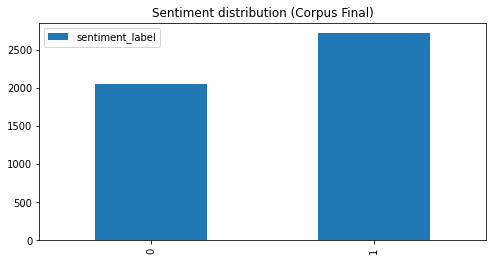

In [25]:
aux_df = pd.DataFrame(train['sentiment_label'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Sentiment distribution (Corpus Final)', figsize=(8, 4))

In [26]:
#contamos las reviews positivas y las negativas
print('Total de etiquetas negativas: ', len(train[train['sentiment_label']== 0]))
print('Total de etiquetas positivas: ',len(train[train['sentiment_label']== 1]))


Total de etiquetas negativas:  2048
Total de etiquetas positivas:  2717


####2.1.3. N-grams más frecuentes

In [27]:
bigrams_ = ngrams(unique_word, 2)
trigrams_ = ngrams(unique_word, 3)

In [28]:
bigrams_freq_ = FreqDist(bigrams_)
trigrams_freq_ = FreqDist(trigrams_)

In [29]:
bigrams_freq_.most_common(10)

[(('parboiled/', 'complimentary'), 1),
 (('complimentary', 'outlaw'), 1),
 (('outlaw', 'foto'), 1),
 (('foto', 'flower'), 1),
 (('flower', 'Mexicans'), 1),
 (('Mexicans', 'believe'), 1),
 (('believe', 'Tso'), 1),
 (('Tso', 'Overpriced'), 1),
 (('Overpriced', '1/2-soup'), 1),
 (('1/2-soup', 'Caribbean'), 1)]

In [30]:
trigrams_freq_.most_common(10)


[(('parboiled/', 'complimentary', 'outlaw'), 1),
 (('complimentary', 'outlaw', 'foto'), 1),
 (('outlaw', 'foto', 'flower'), 1),
 (('foto', 'flower', 'Mexicans'), 1),
 (('flower', 'Mexicans', 'believe'), 1),
 (('Mexicans', 'believe', 'Tso'), 1),
 (('believe', 'Tso', 'Overpriced'), 1),
 (('Tso', 'Overpriced', '1/2-soup'), 1),
 (('Overpriced', '1/2-soup', 'Caribbean'), 1),
 (('1/2-soup', 'Caribbean', 'styles'), 1)]

####2.1.4. Nube de palabras

In [31]:
#convertir mi lista de palabras en una cadena 
#" ".join(unique_word)

In [32]:
#nube de palabras
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

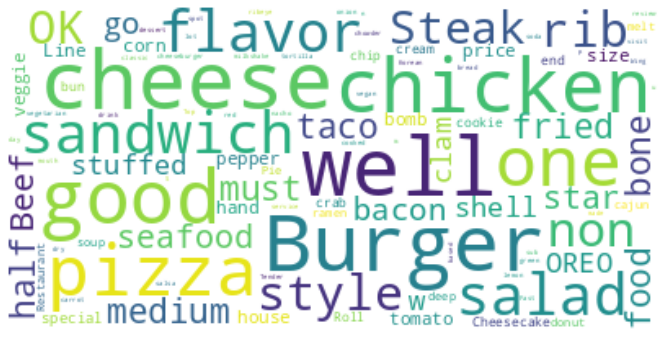

In [33]:
plot_word_cloud(unique_word)

####2.1.5. palabras similares con word2vec

In [34]:
import multiprocessing

from gensim.models import Word2Vec

cores = multiprocessing.cpu_count() # Contamos el número de cores en el ordenador
print (cores)

#hiperparámetros de inicialización 
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)



2


In [35]:
sent = [row for row in train['words']]
w2v_model.build_vocab(sent, progress_per=10000)

In [36]:
print('Vocabulario compuesto por {} palabras'.format(len(w2v_model.wv.vocab)))

Vocabulario compuesto por 807 palabras


In [37]:
#entrenamos el modelo del w2v
w2v_model.train(sent, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(739640, 4184730)

In [38]:
#algunos resultados similares de sentimiento postivo
w2v_model.wv.most_similar(positive=["fresh"])

[('nice', 0.9991568922996521),
 ('Salad', 0.9989580512046814),
 ('especially', 0.9986695647239685),
 ('veggies', 0.9986141324043274),
 ('Had', 0.9984626770019531),
 ('beef', 0.9984019994735718),
 ('Bacon', 0.9984003305435181),
 ('super', 0.9983823299407959),
 ('excellent', 0.9983077049255371),
 ('which', 0.9982235431671143)]

In [39]:
#algunos resultados similares de sentimiento postivo
w2v_model.wv.most_similar(positive=["crispy"])

[('juicy', 0.9994356632232666),
 ('flavorful', 0.9993279576301575),
 ('salty', 0.9993278980255127),
 ('seasoned', 0.9992667436599731),
 ('moist', 0.9990997910499573),
 ('bland', 0.9990412592887878),
 ('cheesy', 0.9990225434303284),
 ('bread', 0.9989244341850281),
 ('perfect', 0.9988952279090881),
 ('egg', 0.998885989189148)]

In [40]:
#algunos resultados similares de sentimiento postivo
w2v_model.wv.most_similar(positive=["chicken"])

[('were', 0.9982781410217285),
 ('beans', 0.9972161054611206),
 ('cheese', 0.9964447021484375),
 ('cooked', 0.9964114427566528),
 ('The', 0.9963738918304443),
 ('fried', 0.9960920810699463),
 ('perfectly', 0.9951759576797485),
 ('mashed', 0.9943486452102661),
 ('rice', 0.9941428899765015),
 ('potatoes', 0.9940364360809326)]

In [41]:
w2v_model.wv.similarity('fresh', 'crispy')

0.9919697

In [42]:
w2v_model.wv.similarity('chicken', 'fries')

0.9909844

In [43]:
w2v_model.save('./w2v_model.pkl')

In [47]:
# almacenamos las imagenes en nuestro drive
!cp w2v_model.pkl /content/drive/MyDrive/NLP/w2v_model.pkl


In [49]:
!ls -lah 

total 5.7M
drwxr-xr-x 1 root root 4.0K Mar  8 10:25 .
drwxr-xr-x 1 root root 4.0K Mar  8 08:01 ..
drwxr-xr-x 4 root root 4.0K Mar  6 17:51 .config
drwx------ 5 root root 4.0K Mar  8 10:25 drive
drwxr-xr-x 1 root root 4.0K Mar  6 17:52 sample_data
-rw-r--r-- 1 root root 2.9M Mar  8 10:42 w2v_model.pkl
-rw-r--r-- 1 root root 2.9M Mar  8 09:45 w2v_model_ts.pkl


In [50]:
#cargamos el modelo 
w2v_sg = Word2Vec.load('./w2v_model.pkl')

In [51]:
keys = ['crispy','salad','pulled']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_sg.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_sg.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [52]:
print(word_clusters)

[['juicy', 'flavorful', 'salty', 'seasoned', 'moist', 'bland', 'cheesy', 'bread', 'perfect', 'egg'], ['side', 'dip', 'baked', 'which', 'beef', 'Shrimp', 'avocado', 'platter', 'tomatoes', 'mushrooms'], ['ribs', 'brisket', 'belly', 'salty', 'juicy', 'flavorful', 'crispy', 'seasoned', 'sides', 'sandwich']]


In [53]:
#reducimos la dimensionalidad para representarlo en 2D
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

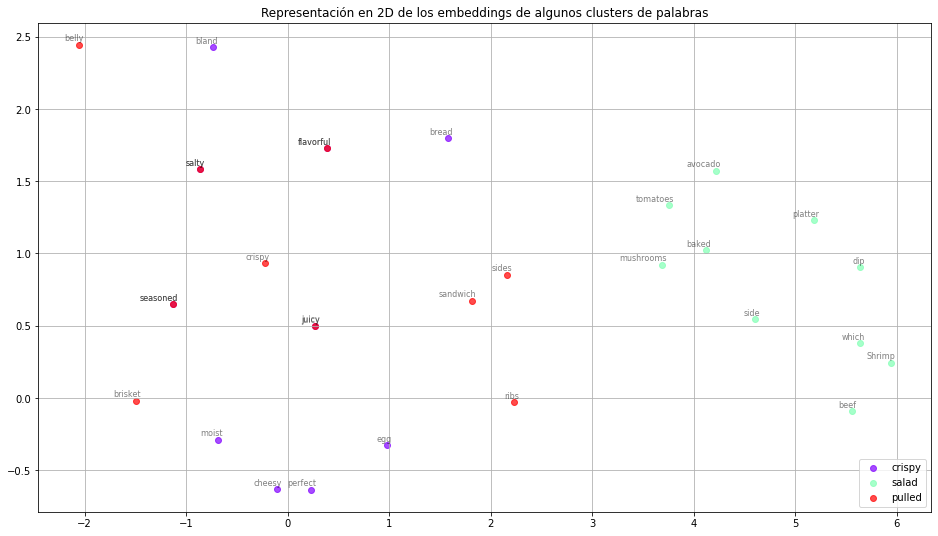

In [54]:
#Representamos los cl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline


def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    # plt.savefig("f/г.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

### 2.2. Ahora el mismo análisis para conjunto test

In [55]:
test

,review_text,reviews_sentiment
170,Next time I want to order bibim naengmyeon and...,5
2125,"Love this place, exelent steaks, chumichurri s...",5
150,My server suggested salt & vinegar seasoning f...,3
5523,"The green beans were shriveled and, quite hone...",1
3313,"So... when one puts up a sign saying ""chicken ...",2
...,...,...
5182,"If you love seafood this is the place for you,...",5
1541,"For starters I had the fritto miso, which is t...",5
5934,A&W has always had smooth root beer. I had for...,5
5247,"The tilapia is very crispy and tastes okay, bu...",3


In [56]:
#convertimos en minúsculas y tokenizamos por espacios 
reviews = train['review_text'].str.lower().str.split() 
train.head()

,review_text,reviews_sentiment,words,sentiment_label
1898,When the pie arrived it was missing one of the...,2,"[When, the, pie, arrived, it, was, missing, on...",1
1889,Burger was fabulous. Bacon tasted like one fro...,5,"[Burger, was, fabulous, ., Bacon, tasted, like...",0
5005,"Some of the food was very good - chicken, spam...",3,"[Some, of, the, food, was, very, good, -, chic...",1
203,This is a solid taco place. But their tortilla...,4,"[This, is, solid, taco, place, ., But, their, ...",1
2890,"I had the mahi mahi tacos, which were pretty g...",4,"[I, had, the, mahi, mahi, tacos, ,, which, wer...",1


#### 2.1.1. Cardinalidad del vocabulario

In [57]:
#llamamos a nuestra función word_count
test['words'] = test['review_text'].apply(word_count)
test.head()

,review_text,reviews_sentiment,words
170,Next time I want to order bibim naengmyeon and...,5,"[Next, time, I, want, to, order, bibim, naengm..."
2125,"Love this place, exelent steaks, chumichurri s...",5,"[Love, this, place, ,, exelent, steaks, ,, chu..."
150,My server suggested salt & vinegar seasoning f...,3,"[My, server, suggested, salt, &, vinegar, seas..."
5523,"The green beans were shriveled and, quite hone...",1,"[The, green, beans, were, shriveled, and, ,, q..."
3313,"So... when one puts up a sign saying ""chicken ...",2,"[So, ..., when, one, puts, up, sign, saying, `..."


In [58]:
#creamos una lista con la suma de las palabras de todas las reviews
words_ts = list(test['words'].sum())
words_ts

['Next',
 'time',
 'I',
 'want',
 'to',
 'order',
 'bibim',
 'naengmyeon',
 'and',
 'dumplings',
 'and',
 'try',
 'another',
 'one',
 '.',
 'And',
 'the',
 'boss',
 'and',
 'the',
 'staff',
 'were',
 'kind',
 'and',
 'it',
 'was',
 'really',
 'nice',
 '.',
 'The',
 'dumplings',
 'and',
 'bibim',
 'naengmyeon',
 'are',
 'delicious',
 '.',
 'Bibim',
 'naengmyeon',
 'was',
 'very',
 'delicious',
 'among',
 'places',
 'I',
 "'ve",
 'ever',
 'eaten',
 '.',
 'Mulnaengmyeon',
 'is',
 'normal',
 '.',
 'They',
 'give',
 'the',
 'broth',
 ',',
 'but',
 'it',
 "'s",
 'really',
 'delicious',
 ',',
 'so',
 'I',
 'want',
 'to',
 'go',
 'back',
 'to',
 'the',
 'broth',
 '.',
 'Love',
 'this',
 'place',
 ',',
 'exelent',
 'steaks',
 ',',
 'chumichurri',
 'steak',
 'just',
 'perfect',
 'taste',
 '.',
 'And',
 'thar',
 'garlic',
 'union',
 'sauce',
 'My',
 'server',
 'suggested',
 'salt',
 '&',
 'vinegar',
 'seasoning',
 'for',
 'the',
 'tater',
 'tots',
 'and',
 'they',
 'were',
 'awesome',
 '!',
 'The

In [59]:
#visualizamos las palabras sin duplicados
unique_word_ts= list(set(test['words'].sum()))
unique_word_ts

['parboiled/',
 'complimentary',
 'believe',
 'Overpriced',
 'styles',
 'Magical',
 'smothered',
 'curd',
 'sunny',
 'want',
 'nothing',
 'sitting',
 'mild',
 'Instant',
 'french',
 'pareja',
 'strawberry',
 'ultra-full',
 'sodium',
 'chillies',
 'arroz',
 'cereal',
 'Haha',
 'Crabs',
 'rancher',
 'croissants',
 'sue',
 'power',
 'easily',
 'consider',
 'aoli',
 'wrong',
 'mad',
 'parsley',
 'celery',
 'pairing',
 'charming',
 'French',
 'bowling',
 'kinds',
 'mom',
 'beed',
 'noodles',
 'decided',
 'cafeteria',
 'States',
 'Jambalaya',
 'donut',
 'stickers',
 'Smoked',
 'white',
 'Mignon',
 'making',
 'her',
 'sandwichthought',
 'omelette',
 'dust',
 'marinaded',
 'Banana-Pudding',
 'beers',
 'favorite',
 '~',
 'tenderloin',
 'blandness',
 'iceberg',
 'mahi',
 'melt',
 'beat',
 'hungry',
 'Pacific',
 'pleasant',
 'Dan-osauras',
 'jerk',
 'located',
 'later',
 'ramen',
 'parsnip',
 'experimenting',
 'Stay',
 'exelent',
 'Hair',
 'tantissime',
 'Tex-mex',
 'regular',
 'Whatever',
 'Bock

In [60]:
total_words_ts = len(words_ts)
total_words_ts

46612

In [61]:
total_unique_words_ts = len(unique_word_ts)
total_unique_words_ts

5276

#### 2.1.2. Análisis de sentimiento

In [62]:
#analizo el sentimiento en el punto medio 
test[test['reviews_sentiment']== 3]

,review_text,reviews_sentiment,words
150,My server suggested salt & vinegar seasoning f...,3,"[My, server, suggested, salt, &, vinegar, seas..."
3488,"The crab cake Sandwich was $15, the crab cake ...",3,"[The, crab, cake, Sandwich, was, $, 15, ,, the..."
6077,The batter on the fish was a little thick so i...,3,"[The, batter, on, the, fish, was, little, thic..."
5989,The buffalo is way too sour for me!,3,"[The, buffalo, is, way, too, sour, for, !]"
1645,"The omelette needed some spice, but the home f...",3,"[The, omelette, needed, some, spice, ,, but, t..."
...,...,...,...
5490,Ordered the charcoal pancake and the eel taco....,3,"[Ordered, the, charcoal, pancake, and, the, ee..."
3105,I ordered the pork chop based off the delectab...,3,"[I, ordered, the, pork, chop, based, off, the,..."
1622,My wife had the pulled pork and I had the cock...,3,"[My, wife, had, the, pulled, pork, and, I, had..."
5174,I ordered the chilaquiles which was really goo...,3,"[I, ordered, the, chilaquiles, which, was, rea..."


In [63]:
#aplico las etiquetas de sentimiento y las meto en una columna
test['sentiment_label'] = test.apply(lambda row: label_sentiment(row), axis=1)

In [64]:
test.head()

,review_text,reviews_sentiment,words,sentiment_label
170,Next time I want to order bibim naengmyeon and...,5,"[Next, time, I, want, to, order, bibim, naengm...",0
2125,"Love this place, exelent steaks, chumichurri s...",5,"[Love, this, place, ,, exelent, steaks, ,, chu...",0
150,My server suggested salt & vinegar seasoning f...,3,"[My, server, suggested, salt, &, vinegar, seas...",1
5523,"The green beans were shriveled and, quite hone...",1,"[The, green, beans, were, shriveled, and, ,, q...",1
3313,"So... when one puts up a sign saying ""chicken ...",2,"[So, ..., when, one, puts, up, sign, saying, `...",1


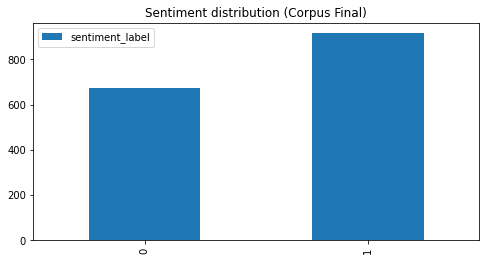

In [65]:
aux_df_ts = pd.DataFrame(test['sentiment_label'].value_counts(sort=False).sort_index())
aux_df_ts = aux_df_ts.plot(kind='bar', title='Sentiment distribution (Corpus Final)', figsize=(8, 4))

In [66]:
#contamos las reviews positivas y las negativas
print('Total de etiquetas negativas: ', len(test[test['sentiment_label']== 0]))
print('Total de etiquetas positivas: ',len(test[test['sentiment_label']== 1]))


Total de etiquetas negativas:  674
Total de etiquetas positivas:  915


####2.1.3. N-grams más frecuentes

In [67]:
bigrams_ts = ngrams(unique_word_ts, 2)
trigrams_ts = ngrams(unique_word_ts, 3)

In [68]:
bigrams_freq_ts = FreqDist(bigrams_ts)
trigrams_freq_ts = FreqDist(trigrams_ts)

In [69]:
bigrams_freq_ts.most_common(10)

[(('parboiled/', 'complimentary'), 1),
 (('complimentary', 'believe'), 1),
 (('believe', 'Overpriced'), 1),
 (('Overpriced', 'styles'), 1),
 (('styles', 'Magical'), 1),
 (('Magical', 'smothered'), 1),
 (('smothered', 'curd'), 1),
 (('curd', 'sunny'), 1),
 (('sunny', 'want'), 1),
 (('want', 'nothing'), 1)]

In [70]:
trigrams_freq_ts.most_common(10)


[(('parboiled/', 'complimentary', 'believe'), 1),
 (('complimentary', 'believe', 'Overpriced'), 1),
 (('believe', 'Overpriced', 'styles'), 1),
 (('Overpriced', 'styles', 'Magical'), 1),
 (('styles', 'Magical', 'smothered'), 1),
 (('Magical', 'smothered', 'curd'), 1),
 (('smothered', 'curd', 'sunny'), 1),
 (('curd', 'sunny', 'want'), 1),
 (('sunny', 'want', 'nothing'), 1),
 (('want', 'nothing', 'sitting'), 1)]

####2.1.4. Nube de palabras

In [ ]:
#convertir mi lista de palabras en una cadena 
#" ".join(unique_word)

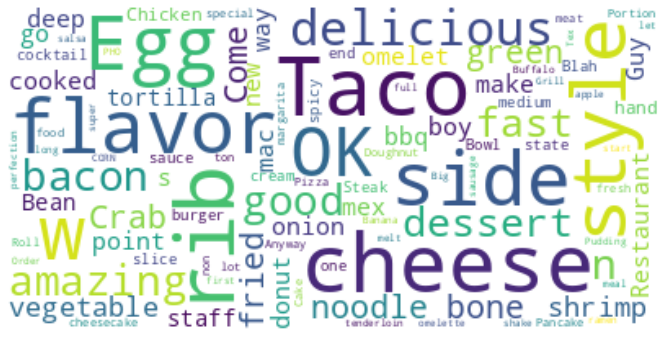

In [71]:
#representamos la nube de palabras
plot_word_cloud(unique_word_ts)

####2.1.5. palabras similares con word2vec

In [72]:
import multiprocessing

from gensim.models import Word2Vec

cores = multiprocessing.cpu_count() # Contamos el número de cores en el ordenador
print (cores)

#hiperparámetros de inicialización 
w2v_model_ts = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)



2


In [73]:
sent = [row for row in train['words']]
w2v_model_ts.build_vocab(sent, progress_per=10000)

In [74]:
print('Vocabulario compuesto por {} palabras'.format(len(w2v_model_ts.wv.vocab)))

Vocabulario compuesto por 807 palabras


In [75]:
#entrenamos el modelo del w2v
w2v_model_ts.train(sent, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(739640, 4184730)

In [76]:
#algunos resultados similares de sentimiento postivo
w2v_model_ts.wv.most_similar(positive=["fresh"])

[('nice', 0.9991568922996521),
 ('Salad', 0.9989580512046814),
 ('especially', 0.9986695647239685),
 ('veggies', 0.9986141324043274),
 ('Had', 0.9984626770019531),
 ('beef', 0.9984019994735718),
 ('Bacon', 0.9984003305435181),
 ('super', 0.9983823299407959),
 ('excellent', 0.9983077049255371),
 ('which', 0.9982235431671143)]

In [77]:
#algunos resultados similares de sentimiento postivo
w2v_model_ts.wv.most_similar(positive=["crispy"])

[('juicy', 0.9994356632232666),
 ('flavorful', 0.9993279576301575),
 ('salty', 0.9993278980255127),
 ('seasoned', 0.9992667436599731),
 ('moist', 0.9990997910499573),
 ('bland', 0.9990412592887878),
 ('cheesy', 0.9990225434303284),
 ('bread', 0.9989244341850281),
 ('perfect', 0.9988952279090881),
 ('egg', 0.998885989189148)]

In [78]:
#algunos resultados similares de sentimiento postivo
w2v_model_ts.wv.most_similar(positive=["chicken"])

[('were', 0.9982781410217285),
 ('beans', 0.9972161054611206),
 ('cheese', 0.9964447021484375),
 ('cooked', 0.9964114427566528),
 ('The', 0.9963738918304443),
 ('fried', 0.9960920810699463),
 ('perfectly', 0.9951759576797485),
 ('mashed', 0.9943486452102661),
 ('rice', 0.9941428899765015),
 ('potatoes', 0.9940364360809326)]

In [79]:
w2v_model_ts.wv.similarity('fresh', 'crispy')

0.9919697

In [80]:
w2v_model_ts.wv.similarity('chicken', 'fries')

0.9909844

In [81]:
w2v_model_ts.save('./w2v_model_ts.pkl')

In [82]:
# almacenamos las imagenes en nuestro drive
!cp w2v_model_ts.pkl /content/drive/MyDrive/NLP/w2v_model_ts.pkl


In [83]:
!ls -lah w2v_model_ts.pkl

-rw-r--r-- 1 root root 2.9M Mar  8 10:46 w2v_model_ts.pkl


In [84]:
#cargamos el modelo 
w2v_sg_ts = Word2Vec.load('./w2v_model_ts.pkl')

In [85]:
keys_ts = ['amazing','creamy','fries']

embedding_clusters_ts = []
word_clusters_ts = []
for word in keys_ts:
    embeddings = []
    words = []
    for similar_word, _ in w2v_sg.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_sg.wv[similar_word])
    embedding_clusters_ts.append(embeddings)
    word_clusters_ts.append(words)

In [86]:
print(word_clusters_ts)

[['incredible', 'yummy', 'absolutely', 'fruit', 'wine', 'filling', 'prepared', 'covered', 'wings', 'Got'], ['tasty', 'spinach', 'salmon', 'delicious', 'sausage', 'bread', 'sides', 'flavorful', 'baked', 'grits'], ['sausage', 'mac', 'spinach', 'potato', 'sides', 'Mac', 'bread', 'sweet', 'crispy', 'grits']]


In [87]:
#reducimos la dimensionalidad para representarlo en 2D
tsne_model_2d_ts = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

embed_clusters_ts = np.array(embedding_clusters_ts)
n, m, k = embed_clusters_ts.shape

embeddings_2d_ts = np.array(tsne_model_2d.fit_transform(embed_clusters_ts.reshape(n * m, k))).reshape(n, m, 2)

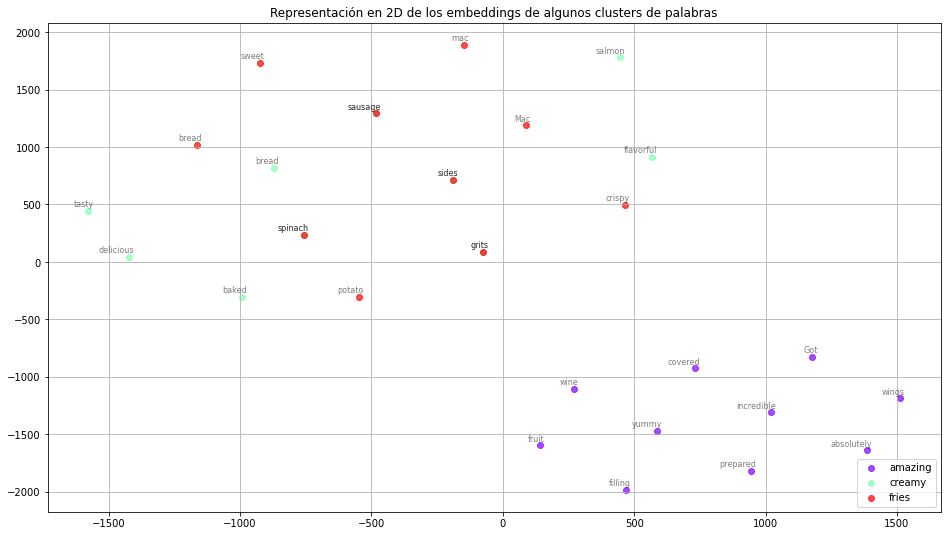

In [88]:
#Representamos los clusters

tsne_plot_similar_words(keys_ts, embeddings_2d_ts, word_clusters_ts)

### 2.3 Conclusiones del análisis exploratorio


Nos encontramos con un conjunto de palabras bastante sucío con numerosas stopwords, simbolos y signos de puntuación.


#### Guardamos todo en gDrive

In [ ]:
#train.to_csv('./train.csv', sep=';', decimal='.', index=False)
#test.to_csv('./test.csv', sep=';', decimal='.', index=False)

In [89]:
# guardamos los dfs

train.to_csv('train.csv', encoding='utf-8', index=False)
test.to_csv('test.csv', encoding='utf-8', index=False)


In [92]:
#compruebo que los he guardado en mi disco de colab
!ls -lah   

total 8.1M
drwxr-xr-x 1 root root 4.0K Mar  8 10:49 .
drwxr-xr-x 1 root root 4.0K Mar  8 08:01 ..
drwxr-xr-x 4 root root 4.0K Mar  6 17:51 .config
drwx------ 5 root root 4.0K Mar  8 10:25 drive
drwxr-xr-x 1 root root 4.0K Mar  6 17:52 sample_data
-rw-r--r-- 1 root root 604K Mar  8 10:49 test.csv
-rw-r--r-- 1 root root 1.8M Mar  8 10:49 train.csv
-rw-r--r-- 1 root root 2.9M Mar  8 10:42 w2v_model.pkl
-rw-r--r-- 1 root root 2.9M Mar  8 10:46 w2v_model_ts.pkl


In [90]:
# lo movemos a nuestro en nuestro google drive
!cp /content/train.csv /content/drive/MyDrive/NLP/train.csv
!cp /content/test.csv /content/drive/MyDrive/NLP/test.csv